In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl=pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco=pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm=pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn=pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [3]:
stocks=pd.concat([aapl,cisco,ibm,amzn],axis=1)
stocks.columns=['aapl','cisco','ibm','amzn']

In [4]:
#daily returns arithmetically
stocks.pct_change(1).head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [5]:
#daily returns logarithmically
log_ret=np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11af9d9e8>,
      dtype=object)

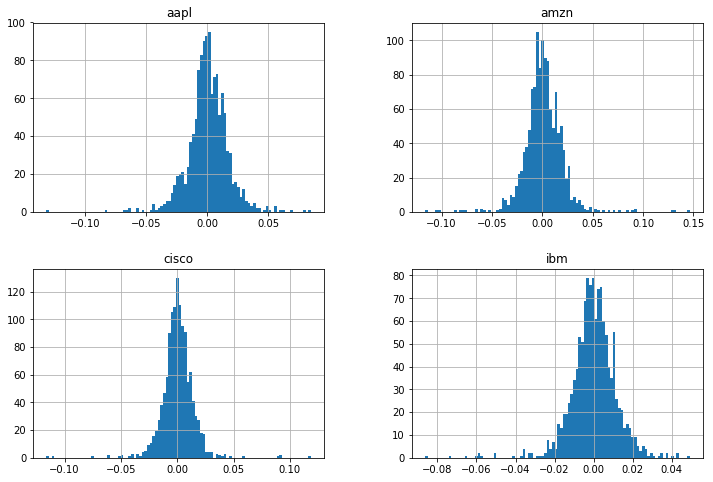

In [6]:
log_ret.hist(bins=100,figsize=(12,8))

In [7]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [8]:
#annualized covariance
log_ret.cov()*252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [9]:
####### METHOD 1: USING MONTE CARLO SIMULATION #####


np.random.seed(101)

num_ports=5000
all_weights=np.zeros((num_ports,len(stocks.columns)))
ret_arr=np.zeros(num_ports)
vol_arr=np.zeros(num_ports)
sharpe_arr=np.zeros(num_ports)

for i in range(num_ports):
    
    
    #Weights
    weights=np.array(np.random.random(4))
    #Do below to make sure they all add up to 100%
    weights=weights/np.sum(weights)
    #Save weights
    all_weights[i,:]=weights

    #Expected Return
    
    ret_arr[i]=np.sum(log_ret.mean()*weights*252)


    #Expected volatility

    vol_arr[i]=np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    
    #Sharpe ratio

    sharpe_arr[i]=ret_arr[i]/vol_arr[i]

In [10]:
#Find the max value
sharpe_arr.max()

1.0303260551271067

In [11]:
#Find the index location of the max value of Sharpe ratio
sharpe_arr.argmax()

1420

In [12]:
#The index location of the max value of Sharpe ratio is 1420
#find the optimal weights
all_weights[1420,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [13]:
#The index location of ret_arr and vol_arr which corresponds to the max Sharpe ratio
max_sr_ret=ret_arr[1420]
max_sr_vol=vol_arr[1420]

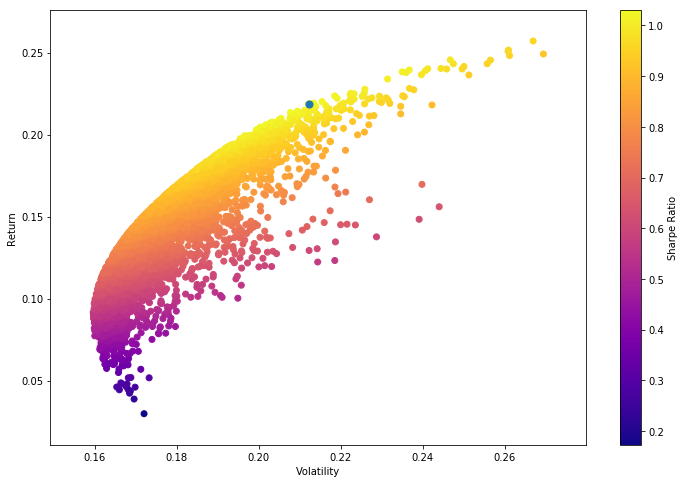

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#Plot the location where the sharpe ratio is max value
plt.scatter(max_sr_vol,max_sr_ret,s=50)

In [15]:
###### METHOD 2: USING SCIPY OPTIMIZER ######
def get_ret_vol_sr(weights):
    weights=np.array(weights)
    ret=np.sum(log_ret.mean()*weights*252)
    vol=np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr=ret/vol
    return np.array([ret,vol,sr])

In [16]:
from scipy.optimize import minimize

In [18]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [19]:
#convert sharpe ratio into a negative value
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]*-1

In [30]:
def check_sum(weights):
    #return 0 if the sum of weights is 1
    return np.sum(weights)-1

In [35]:
#specify the constraints: the constraints which will be passed to the minimize function has to be a list of dictionaries
#type=equality: Equality constraint means that the constraint function result needs to be zero
#function=check_sum
cons=({'type':'eq',"fun":check_sum})

In [42]:
bounds=((0,1),(0,1),(0,1),(0,1))


In [43]:
initial_guess=[0.25,0.25,0.25,0.25]

In [44]:
#find optimal results
opt_results=minimize(neg_sharpe,initial_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [45]:
opt_results

     fun: -1.0307168703360183
     jac: array([ 5.64306974e-05,  4.18126583e-05,  3.39921713e-01, -4.44948673e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628977, 0.20418981, 0.        , 0.52952042])

In [49]:
#Find the optimal weights
opt_weights=opt_results.x
print(opt_weights)

[0.26628977 0.20418981 0.         0.52952042]


In [48]:
#Find the return, volatility, and sharpe ratio at the optimal weights 
get_ret_vol_sr(opt_weights)

array([0.21885916, 0.21233683, 1.03071687])

In [55]:
##### FIND THE EFFICIENT FRONTIER LINE #######
#As seen from the plot above, the y-value of the efficient frontier is only from 0 to 0.3
frontier_y=np.linspace(0,0.3,100)

In [56]:
#need to minimize the volatility (x-value)
def minimize_vol(weights):
    #return volatility which is index number 1
    return get_ret_vol_sr(weights)[1]

In [57]:
frontier_volatility=[]

for possible_return in frontier_y:
    #There are 2 constraints: 1. all the weights add up to 100% ; 2. the possible return is equal to the return 
    #that is obtained from the get_ret_vol_sr() function
    cons=({'type':'eq', 'fun':check_sum},{'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0]-possible_return})
    
    result=minimize(minimize_vol,initial_guess,method='SLSQP',bounds=bounds,constraints=cons)
    #add the minimized vol value to the empty list frontier_volatility
    frontier_volatility.append(result['fun'])

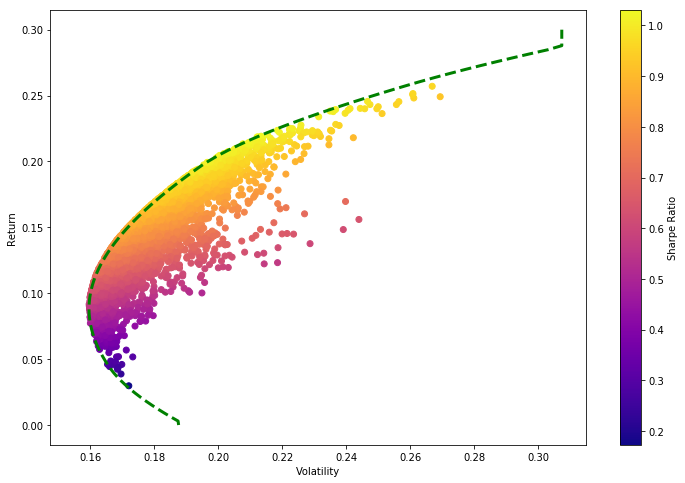

In [59]:
#Return, vol, and SR plot (same as above)
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#Plot the efficient frontier curve
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
#Efficient frontier shows: For each possible vol level, what is the max return you can get?